Forested Protected Lands
===

This notebook overlays the DRWI protected lands and WeConservePA protected lands with the 2019 NLCD land use data using the ModelMyWatershed api. 

The goal of this notebook is to identify whether protected lands overlap with forested areas.

# Setup

## Imports

In [1]:
# Import packages
from pathlib import Path
import math
import numpy as np
import pandas as pd
import geopandas as gpd

# Plotting packages
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from pyproj import CRS
from shapely.validation import make_valid
import colorcet as cc
from colorcet.plotting import swatch, swatches, sine_combs
import contextily as ctx

## File paths

In [2]:
# Find your current working directory, which should be folder for this notebook.
Path.cwd()

WindowsPath('C:/Users/clulay/OneDrive - LimnoTech/Documents/GitHub/pollution-assessment/stage2/Protected_Lands')

In [3]:
# Set your project directory to your local folder for your clone of this repository
project_path = Path.cwd().parent.parent
project_path

WindowsPath('C:/Users/clulay/OneDrive - LimnoTech/Documents/GitHub/pollution-assessment')

In [4]:
# Path to WeConservePA protected lands shapefile
wcpa_path = project_path / Path('stage2/Protected_Lands/WeConservePA_pl_20220810.shp')
wcpa_path.exists()

True

## Private file paths
- Download from https://drive.google.com/drive/folders/1HKlnA3lC2xvKBQ1bg1J08gsEB3N9rp2V
- Save in `stage2/private` folder

In [5]:
# Path to FieldDoc protected lands export file
fielddoc_path = project_path / Path('stage2/private/protection_bmps_from_FieldDoc.parquet')
fielddoc_path.exists()

True

# Load data

## Protected Lands from WeConservePA

In [33]:
# Import weconservePA protected lands
wcpa_gdf = gpd.read_file(wcpa_path)

In [34]:
# Add data source tag
wcpa_gdf['data_source'] = 'weconservePA_2022'

### Convert Object to Category dtype

In [8]:
wcpa_dtypes = {
    'Category': 'category',
    'sitename': 'category',
    'esmthldr': 'category',
    'eholdtype': 'category',
    'own_name': 'category',
    'own_type': 'category',
    'purpose': 'category',
    'pubaccess': 'category',
    'Landscape': 'category',
    'Cluster': 'category',
    'LTSA': 'category',
    'WTRSA': 'category',
    'State_abb': 'category',
    'State': 'category',
    'County': 'category',
    'Municipali': 'category',
    'Muni_Type': 'category',
    'Muni': 'category',
    'MMW': 'category',
    'RECLASS2': 'category',
    'data_source': 'category'
}

In [9]:
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.astype.html
wcpa_gdf = wcpa_gdf.astype(wcpa_dtypes)

In [10]:
wcpa_gdf.RECLASS2.unique()

['Agricultural Easement', 'Conservation Easement', 'Park or Recreation Area - Federal', 'Natural Resource Area - Federal', 'Natural Resource Area - Local', 'Park or Recreation Area - Local', 'Natural Resource Area - Private', 'Park or Recreation Area - Private', 'Park or Recreation Area - State', 'Natural Resource Area - State']
Categories (10, object): ['Agricultural Easement', 'Conservation Easement', 'Natural Resource Area - Federal', 'Natural Resource Area - Local', ..., 'Park or Recreation Area - Federal', 'Park or Recreation Area - Local', 'Park or Recreation Area - Private', 'Park or Recreation Area - State']

In [11]:
# Rename area column
wcpa_gdf.rename(columns={'gis_acres': 'Area_Ac'}, inplace=True)

In [12]:
# Convert WeConservePA protected lands shapefile to geojson for MMW api
#wcpa_gdf.to_file('wcpa.geojson', driver='GeoJSON')

## Protected Lands from FieldDoc

In [35]:
# Import FieldDoc protected lands 
fielddoc_gdf = gpd.read_parquet(fielddoc_path)

# Add a column to fielddoc_gdf with data source
fielddoc_gdf['data_source'] = 'fielddoc_2022-08-11'
fielddoc_gdf.head(n=1)

,practice_name,practice_id,program_name,program_id,organization,description,practice_type,created_at,modified_at,tot_pwr,head_pwr,nat_land,ara_pwr,wet_pwr,dev_land,ag_land,str_bank,geometry,data_source
0,Bartolacci,5301,Delaware River Watershed Protection Fund - For...,5,Natural Lands Trust,Land Protection \n\nShapefile needs to be load...,Conservation easement,2019-01-14T20:29:48.955938Z,2020-12-21T18:28:07.158142Z,26.0,0.0,39.31,25.94,8.59,0.02,0.0,0.43,"POLYGON ((-75.22603 41.12858, -75.22736 41.128...",fielddoc_2022-08-11


### Convert Object to Category dtype

In [14]:
fielddoc_dtypes = {
    'practice_name': 'category',
    'program_name': 'category',
    'organization': 'category',
    'practice_type': 'category',
    'data_source': 'category'}

In [15]:
fielddoc_gdf = fielddoc_gdf.astype(fielddoc_dtypes)

## DRWI Geographies

In [16]:
# Import cluster and focus area geometries
cluster_gdf = gpd.read_parquet(project_path / Path('stage1/data/cluster_df.parquet'))  
focusarea_gdf = gpd.read_parquet(project_path / Path('stage1/data/fa_phase2_df.parquet'))

focusarea_gdf.cluster = focusarea_gdf.cluster.replace('Kirkwood Cohansey Aquifer', 'Kirkwood - Cohansey Aquifer') # update name for consistency with other files 
focusarea_gdf.set_index('name', inplace=True)

# Convert from gdf to geojson

In [48]:
sub_gdf = wcpa_gdf[wcpa_gdf['OBJECTID']==1]
sub_gdf.to_file("wcpa.geojson", driver="GeoJSON")
wcpa_json = json.load(open('wcpa.geojson'))

C:\Users\clulay\.conda\envs\WikiSRAT\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [38]:
fielddoc_gdf.to_file("fielddoc.geojson", driver="GeoJSON")
fd_json = json.load(open('fielddoc.geojson'))

C:\Users\clulay\.conda\envs\WikiSRAT\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


# MMW

In [24]:
import json

import pprint
import requests
import pandas as pd
import panel as pn
from bokeh.resources import INLINE
import holoviews as hv
import time
import geopandas as gpd
import matplotlib.pyplot as plt

In [25]:
MMW_API_URL = 'https://staging.modelmywatershed.org/api'
MMW_API_TOKEN = '82fb0268c9af8aeaac22c01910d344c3389586a2'

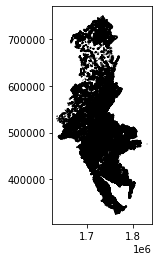

In [64]:
fig, ax = plt.subplots()
wcpa_gdf.geometry.boundary.plot(color=None,edgecolor='k',ax=ax)
plt.show()

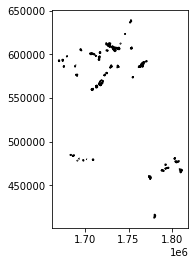

In [34]:
fig, ax = plt.subplots()
fielddoc_gdf.geometry.boundary.plot(color=None,edgecolor='k',ax=ax)
plt.show()

In [70]:
for item in wcpa_json['features']:
    print(item['geometry'])

{'type': 'Polygon', 'coordinates': [[[1751532.3412000015, 407777.85639999993], [1751099.6440999992, 407144.4569000006], [1751068.0034000017, 407481.20749999955], [1750837.419399999, 407360.2606000006], [1751254.0452999994, 407962.57689999975], [1751532.3412000015, 407777.85639999993]], [[1751362.874499999, 407809.9849999994], [1751248.4646000005, 407647.1867999993], [1751297.7331999987, 407611.16929999925], [1751412.143199999, 407773.9673999995], [1751362.874499999, 407809.9849999994]], [[1751186.756099999, 407625.92620000057], [1751125.1702000014, 407670.9480000008], [1751033.6424999982, 407540.7093000002], [1751095.2283000015, 407495.6875], [1751186.756099999, 407625.92620000057]]]}


In [65]:
wcpa_run_dict = {}

#fielddoc_run_dict[test['practice_name']] = {}
for item in wcpa_json['features']:
    

    print(f'Starting...')
    # Set up request
    DATA = {'area_of_interest': item['geometry']}
    HEADERS = {'Authorization': f'Token {MMW_API_TOKEN}'}
    res_base = requests.post(f'{MMW_API_URL}/analyze/land/2019/',data=DATA, headers=HEADERS)

    print('  waiting for id ... ')
    time.sleep(10)
    print(res_base.json())
    #PREPARE_JOB_UUID = res_base.json()['job_uuid']
    #res_base = requests.get(f'{MMW_API_URL}/jobs/{PREPARE_JOB_UUID}/', headers=HEADERS)
    #time.sleep(10)
    
    print('  sending run...')
    

Starting...
  waiting for id ... 
['Area of interest must be valid JSON']
  sending run...
